# Lecture 3, Part 1: Clustering

In this part of the tutorial we are going to explore clustering. We are going to implement $k$-Means, which is a very simple, yet powerful algothim. *K*-Means algorithm clusters data by trying to separate $n$ observations into $k$ clusters. Each observation belongs to the cluster with the nearest mean of the cluster centers also known as *centroids*. The algorithm has three steps: initialization of centroids, and looping over expectation and maximization step. Expectation step assigns each sample to their nearest centroid. The maximization step recalculates new centroids by taking the mean value of all of the samples assigned to each previous centroid.

In [1]:
# Let's import what we need for this part

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

In [2]:
# Let's generate sample data

n_samples = 1000
n_components = 3

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, n_features=2, cluster_std=1, random_state=42
)
X = X[:, ::-1]

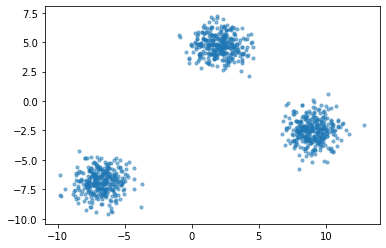

In [3]:
# Our data looks like this:

plt.scatter(X[:,0], X[:,1], s=10, alpha=.5);

In [4]:
# We need to define our distance metric. Let's calculate a simple euclidean distance

def euclidean_distance(X, c):
    return np.linalg.norm(np.array(X-c), axis=1)

We are going to build our k-Means using the algorithm below:

![](https://files.realpython.com/media/kmeans-algorithm.a94498a7ecd2.png)

In [5]:
# Our main metod

class kMeans():
    
    def __init__(self, k, x):
        #Initialize random centroids
        self.c = 5*np.random.random((k,2))
        #Initialize data
        self.x = x
        #Initialize cluster predictions
        self.cluster = None

    def fit_step(self):
        # Expectation: calculate distances
        dist = np.zeros((len(self.x), len(self.c)))
        for idx, _ in enumerate(self.c):     
            dist[:, idx] = euclidean_distance(self.x, _)

        # Assign clusters based on the distance
        self.cluster = np.argmin(dist, axis=1)

        # Maximization: recalcuate cluster centers
        for idx, _ in enumerate(self.c):
            mask = self.cluster == idx
            self.c[idx] = self.x[mask].mean(0)
        
    def get_centroids(self):
        return self.c
    
    def get_y_pred(self):
        return self.cluster

In [6]:
# Initialize your k-Means algorihtm with k=3

my_k_means = kMeans(3, X)

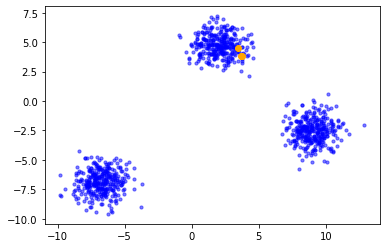

In [7]:
# Let's see where are the initial cluster

centroids = my_k_means.get_centroids()
plt.scatter(X[:,0], X[:,1], s=10, alpha=.5, c='blue') # our original data
plt.scatter(centroids[:, 0], centroids[:, 1], c='orange') # plot centroids 
plt.show();

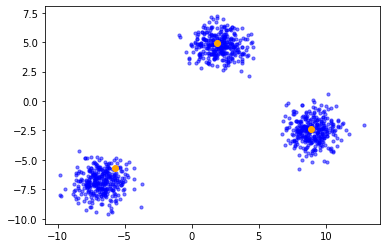

In [8]:
# Let's do only one step of fitting

my_k_means.fit_step()
centroids = my_k_means.get_centroids()
plt.scatter(X[:,0], X[:,1], s=10, alpha=.5, c='blue') # our original data
plt.scatter(centroids[:, 0], centroids[:, 1], c='orange') # plot centroids 
plt.show();

Did the centroids move? Try to execute the cell above until you get a stable result. How many steps did you need?

In [9]:
# Let's check if we clustered the data well.
# y_true should equal to y_pred in all cases, i.e. adjusted_rand_score = 1
# We cannot simply compare y_true == y_pred since the cluster "naming" is not guaranteed

from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(y_true, my_k_means.get_y_pred())

0.8546003770282891

### Your tasks:
 * Warmup exercise: try to plot the clusters with different colors depending on the cluster assigned.
 * Change k to 5 and rerun. What can you conclude? What about k = 2?
 * Implement an elbow method to verify that k should be equal to 3.

# Lecture 3, Part 2: Dimensionality Reduction

In this part we are going to perform dimensionality reduction. Working in high-dimensional spaces can be undesirable for many reasons. But most importantly it is difficult to visualize high-dimensional data. In order to reduce the dimensionality we should transforms original data in a clever way. We will try two techniques: PCA (linear) and t-SNE (non-linear) techinique. PCA tries to maximize the variance in low-dimensional embedding while t-SNE tries to preserve local similarities. Both methods are unsupervised.

From now on we are goint to use a dataset of images of hand writing numbers (MNIST database). It is a popular ML dataset for experiments and learning. It is perfect for the the next few exercises where we want to understand the alogithms and models. Physics datasetes tend to be less trivial.

We will have 70,000 grayscale images of 784 pixels (28x28 px).

In [10]:
# Import torchvision for downloading and processing the dataset

from torchvision import transforms
from torchvision.datasets import MNIST

In [11]:
# Collect the dataset

dataset = MNIST('../data', transform=transforms.ToTensor(), download=True)

In [12]:
# Convert to numpy array

data = dataset.data.numpy().reshape(60000, -1)
targets = dataset.targets.numpy()

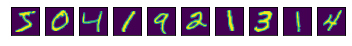

In [13]:
# Let's plot a few samples

figure, axis = plt.subplots(1, 10)
for i in range(10):
    img = data[i]
    img = img.reshape(28, 28)
    axis[i].get_xaxis().set_visible(False)
    axis[i].get_yaxis().set_visible(False)
    axis[i].imshow(img)

Let's start with PCA with two components.

In [14]:
# Finally, let's run PCA with 2 components

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data)

PCA(n_components=2)

In [15]:
# Check the variance ratio for each component

print(pca.explained_variance_ratio_)

[0.09704664 0.07095924]


In [16]:
# Transform the data

low_dim = pca.transform(data)

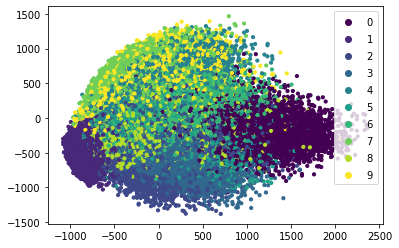

In [17]:
# Plot 2d embeddings

s = plt.scatter(low_dim[:,0], low_dim[:,1], s=10, c=targets)
plt.legend(*s.legend_elements())
plt.show();

Now, let's try a similar exercise for TSNE

In [18]:
# Import TSNE
from sklearn.manifold import TSNE

# Let's reduce the number of dimensions with PCA first to reduce computational complexity
# We will also visualize only 1/6 of the dataset for the same reason

pca = PCA(n_components=50)
embedded = pca.fit_transform(data[:10000])

In [19]:
# Initialize TSNE

tsne = TSNE(n_components=2, init='random')

In [20]:
# Calculate embeddings. This can take a moment

embedded = tsne.fit_transform(embedded)

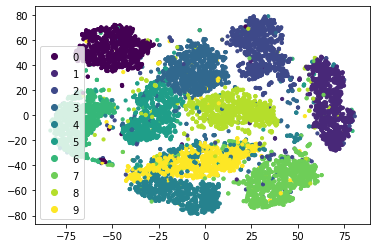

In [21]:
# Plot 2d embeddings

s = plt.scatter(embedded[:,0], embedded[:,1], s=10, c=targets[:10000])
plt.legend(*s.legend_elements());

Would you use TSNE for clustering? Why?

# Lecture 3, Part 3: Autoencoders

In this part, we are going to define and train our Autoencoder.

Autoencoders consists of two neural networks: an encoder *E* and a decoder *D*. Autoencoders take the data in the original space or with noise, maps it to a point in the latent space (usually with lower dimensionality of the input) using *E*, and, finally, attempts to reconstruct the input data with the embedding using *D*. 

Before we jump in, let's define the hyperparameters we will be using for the experiment. We will use a batch size of 64 for training and size 128 for testing. We will train for 10 epochs. The learning rate is set to 0.001.

In [22]:
epochs = 10
batch_size_train = 64
batch_size_test = 128
learning_rate = 0.001

In [23]:
# Import needed libraries

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import sys
from tqdm.notebook import trange

In [24]:
# Let's fix the random seed to have reproducable the results. 
# Later you can try changeing the SEED to see how much does it influence the results

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

**Prepating the dataset**

This is where we will make use of TorchVision and DataLoaders. The first lets us load the dataset in an easy way. 
The latter transforms the data we feed to our neural network. The data is already normalized a range of $(0,1)$ range. We can enable more transformation if we wish, such as cropping or rotations. For this exercise we will only stick with normalization.

In [25]:
# Load the dataset using torchvision.datasets and torch DataLoader class

train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])),
  batch_size=batch_size_train, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])),
  batch_size=batch_size_test, shuffle=True)

We will work with two types of Autoencoders:

 * under-complete AE: the capacity limitation is achieved by low-dimensionality hidden layer; and
 * denoising AE: with the original data is corrupted by noise.  

Both are trained using very similar code but we need to add the noise injection in the second type.

In [27]:
# Let's define our autoencoder

class Autoencoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.encoder_layers = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size))

        self.decoder_layers = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            # PLACEHOLDER FOR THE ACTIVATION FUNCTION
        )

    def encoder(self, x):
        return self.encoder_layers(x)
        
    def decoder(self, x):
        return self.decoder_layers(x)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Your task: pass a proper activation function in a placeholder above. Remember the input data is  $x \in (0,1)$. You can use this [cheat sheet](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) to select correct layer.

In [28]:
# We are going to use the same utils as in Lecture 2

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':1.5f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{avg' + self.fmt + '} ({name})'
        return fmtstr.format(**self.__dict__)

In [29]:
# Initialize the autoencoder
ae = Autoencoder(16)

# Define our loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)

In [30]:
loss = AverageMeter('Loss')
train_loss, val_loss = [], []

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    ae.train()
    # Reset our meters
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, targets in train_dataloader:

        inputs = inputs.view(inputs.size(0), -1)

        # Remove previous gradients
        optimizer.zero_grad()
        
        # Feed forward the input
        outputs = ae(inputs)
        
        # Compute the loss and accuracy
        loss_batch = criterion(outputs, inputs)
        loss.update(loss_batch.data)
        
        # Show the current results
        tr.set_description('Epoch {}, {}'.format(epoch+1, loss))
        tr.update(1)

        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer.step()
        
    train_loss.append(loss.avg)
    
    # Validation for each epoch
    ae.eval()
    loss.reset()

    tr = trange(len(val_dataloader), file=sys.stdout)

    for inputs, targets in val_dataloader:

        inputs = inputs.view(inputs.size(0), -1)
        outputs = ae(inputs)
        loss_batch = criterion(outputs, inputs)
        loss.update(loss_batch.data)
        tr.set_description('Validation, {}'.format(loss))
        tr.update(1)

    val_loss.append(loss.avg)

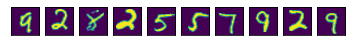

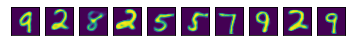

In [31]:
# Let's plot a few samples to see if the autoencoder do a good job at reconstructing the samples.

figure1, axis1 = plt.subplots(1, 10)
figure2, axis2 = plt.subplots(1, 10)
ae.eval()
for img, target in val_dataloader:
    img = img.view(img.size(0), -1)
    output = ae(img)
    
    for i in range(10):
        axis1[i].get_xaxis().set_visible(False)
        axis1[i].get_yaxis().set_visible(False)
        axis1[i].imshow(img[i].view(28, 28))
        
        axis2[i].get_xaxis().set_visible(False)
        axis2[i].get_yaxis().set_visible(False)
        axis2[i].imshow(output[i].detach().view(28, 28))
    break

This works pretty well! Let's check if the model will be able to remove noise from the input samples.

## Denoising Autoencoder

The architecture of a denoising autoencoder doesn't change. What changes is the training setup. We need to corrupt the input samples before the forward pass. Be careful: the target we wat the autoencoder to reconstruct is still the uncorrupted input.

In [40]:
def make_noisy(X, factor=1.):
    return X + factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [41]:
ae_denoise = Autoencoder(10)

# Define our loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(ae_denoise.parameters(), lr=learning_rate)

loss = AverageMeter('Loss')
train_loss, val_loss = [], []

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    ae_denoise.train()
    # Reset our meters
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, targets in train_dataloader:
        
        inputs = inputs.view(inputs.size(0), -1)
        inputs_noisy = make_noisy(inputs).float()
        
        # Remove previous gradients
        optimizer.zero_grad()
        
        # Feed forward the input
        outputs = ae_denoise(inputs_noisy)

        # Compute the loss and accuracy
        loss_batch = criterion(outputs, inputs)
        loss.update(loss_batch.data)
        
        # Show the current results
        tr.set_description('Epoch {}, {}'.format(epoch+1, loss))
        tr.update(1)

        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer.step()
        
    train_loss.append(loss.avg)
    
    # Validation for each epoch
    ae_denoise.eval()
    loss.reset()

    tr = trange(len(val_dataloader), file=sys.stdout)

    for inputs, targets in val_dataloader:

        inputs = inputs.view(inputs.size(0), -1)
        inputs_noisy = make_noisy(inputs).float()
        outputs = ae_denoise(inputs_noisy)
        loss_batch = criterion(outputs, inputs)
        loss.update(loss_batch.data)
        tr.set_description('Validation, {}'.format(loss))
        tr.update(1)

    val_loss.append(loss.avg)

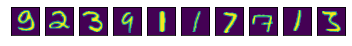

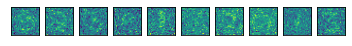

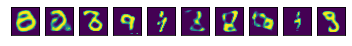

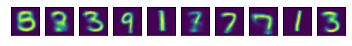

In [42]:
# Let's plot a few samples to see if the autoencoder can remove the noise we insterted

figure1, axis1 = plt.subplots(1, 10)
figure2, axis2 = plt.subplots(1, 10)
figure3, axis3 = plt.subplots(1, 10)
figure4, axis4 = plt.subplots(1, 10)

ae_denoise.eval()

for img, target in val_dataloader:
    img = img.view(img.size(0), -1)
    img_noisy = make_noisy(img).float()
    output_ae = ae(img_noisy)
    output = ae_denoise(img_noisy)
    
    for i in range(10):
        axis1[i].get_xaxis().set_visible(False)
        axis1[i].get_yaxis().set_visible(False)
        axis1[i].imshow(img[i].view(28, 28))
        
        axis2[i].get_xaxis().set_visible(False)
        axis2[i].get_yaxis().set_visible(False)
        axis2[i].imshow(img_noisy[i].view(28, 28))
        
        axis3[i].get_xaxis().set_visible(False)
        axis3[i].get_yaxis().set_visible(False)
        axis3[i].imshow(output_ae[i].detach().view(28, 28))
        
        axis4[i].get_xaxis().set_visible(False)
        axis4[i].get_yaxis().set_visible(False)
        axis4[i].imshow(output[i].detach().view(28, 28))
    break

### Your task: Increase the strnegth of the noise and retrain the network to see the if it can still perform well

# Lecture 3, Part 4: Variational Autoencoders

Variational Autoencoders (VAEs) learn a latent variable model the input data. Instead of having a deterministic mapping like in vanill autoencoder we have just trained, VAE learns a probability distribution over the latent variables. When sampling from this distribution, we can generate new, artificial data samples. Hence, we say that a VAE is a *generative model*. Let's write a VAE model in PyTorch first. You will see there is not a lot of changes compared to the model we have defined above.

In [53]:
# We are going to define our VAE here. Notice that we changed only two things:

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()

        # Encoder layers 
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        # Change 1: encoder output has two nodes corresponsing to mean and variance of the distribution
        self.fc3_log_var = nn.Linear(128, latent_size)
        self.fc3_mu = nn.Linear(128, latent_size)

        # Decoder layers 
        self.fc4 = nn.Linear(latent_size, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 28*28)
        
    def encoder(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3_mu(x), self.fc3_log_var(x) # Two outputs: mean and log of variance
    
    def decoder(self, z):
        x = F.relu(self.fc4(z))
        x = F.relu(self.fc5(x))
        return F.sigmoid(self.fc6(x))
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        # Change 2: we added sampling from the distribution 
        z = self.sampling(mu, log_var)
        x = self.decoder(z)
        return x, mu, log_var

We trained the model with a loss consisting of two parts. A reconstruction part (MSE, BCE) forces the decoded samples to match the initial inputs (same as before). The KL-divergence between the learned latent distribution and the prior distribution (Gaussian), acting as a regularization term.

In [75]:
# Another change between AE and VAE is the loss function:

def loss_function(output, x, mu, log_var):
    reconstruction = F.binary_cross_entropy(output, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (reconstruction + kl_divergence) / output.size(0)

Note: it is very common to introduce a $\beta$ parameter that regulates the strength of the second term. It is very common that KL-divergence falls to the prior completetely, i.e. `kl_divergence = 0`. This prevents the model to learn anything useful. To combat that we set $\beta < 1$ and commonly increase it after initial phases of the training.

In [76]:
# Let's define our VAE

vae = VAE(10)
epochs = 20

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [77]:
# Training and testing the VAE. It is the same as vanilla autoeconder apart from the loss function

loss = AverageMeter('Loss')
train_loss, val_loss = [], []

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    vae.train()
    # Reset our meters
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, targets in train_dataloader:
        
        # Add the noise
        inputs = inputs.view(inputs.size(0), -1)
        
        # Remove previous gradients
        optimizer.zero_grad()
        
        # Feed forward the input
        output, mu, log_var = vae(inputs)

        # HERE: This is the only change in the training setup
        loss_batch = loss_function(output, inputs, mu, log_var)
        
        # Compute the loss and accuracy
        loss.update(loss_batch.data)
        
        # Show the current results
        tr.set_description('Epoch {}, {}'.format(epoch+1, loss))
        tr.update(1)

        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer.step()
        
    train_loss.append(loss.avg)
    
    # Validation for each epoch
    vae.eval()
    loss.reset()

    tr = trange(len(val_dataloader), file=sys.stdout)

    for inputs, targets in val_dataloader:

        inputs = inputs.view(inputs.size(0), -1)
        output, mu, log_var = vae(inputs)
        loss_batch = loss_function(output, inputs, mu, log_var)
        loss.update(loss_batch.data)
        tr.set_description('Validation, {}'.format(loss))
        tr.update(1)

    val_loss.append(loss.avg)

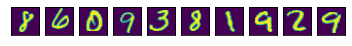

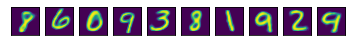

In [78]:
# Let's plot a few samples

figure1, axis1 = plt.subplots(1, 10)
figure2, axis2 = plt.subplots(1, 10)
vae.eval()
for img, target in val_dataloader:
    img = img.view(img.size(0), -1)
    output = vae(img)
    
    for i in range(10):
        axis1[i].get_xaxis().set_visible(False)
        axis1[i].get_yaxis().set_visible(False)
        axis1[i].imshow(img[i].view(28, 28))
        
        axis2[i].get_xaxis().set_visible(False)
        axis2[i].get_yaxis().set_visible(False)
        axis2[i].imshow(output[0][i].detach().view(28, 28))
    break

## VAEs: generating new samples

In this part we are going to generate new samples by interpolating between two real ones. We are going to compare VAE with a vanila autoencoder.

In [79]:
# Let's choose two samples to interpolate between

X_batch, y_batch = next(iter(val_dataloader))
A, y1 = X_batch[0], y_batch[0]
B, y2 = X_batch[1], y_batch[1]

In [ ]:
# Let's try to generate few new samples using out decoder

figure1, axis1 = plt.subplots(1, 10)

vae.eval()
code_for_A = vae.encoder(A.view(1, 1, 28*28))[0]
code_for_B = vae.encoder(B.view(1, 1, 28*28))[0]

code_for_A = code_for_A.detach().numpy()
code_for_B = code_for_B.detach().numpy()

interpolation = np.linspace(code_for_A, code_for_B, 10)

print("From {} to {}".format(y1, y2))
for i, code in enumerate(interpolation):
    img = vae.decoder(torch.tensor(code)).view(28, 28)
    axis1[i].get_xaxis().set_visible(False)
    axis1[i].get_yaxis().set_visible(False)
    axis1[i].imshow(img.detach().numpy())


From 9 to 1


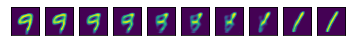

In [81]:
# Let's compare it to the vanilla autoencoder

figure1, axis1 = plt.subplots(1, 10)

ae.eval()
code_for_A = ae.encoder(A.view(1, 1, 28*28))
code_for_B = ae.encoder(B.view(1, 1, 28*28))

code_for_A = code_for_A.detach().numpy()
code_for_B = code_for_B.detach().numpy()

interpolation = np.linspace(code_for_A, code_for_B, 10)

print("From {} to {}".format(y1, y2))
for i, code in enumerate(interpolation):
    img = ae.decoder(torch.tensor(code)).view(28, 28)
    axis1[i].get_xaxis().set_visible(False)
    axis1[i].get_yaxis().set_visible(False)
    axis1[i].imshow(img.detach().numpy())

Do you think there is difference? Digits may be tricky but with real-world images (faces, objects) the difference is clearly visible.

### Your task: MNIST digits are actually images. It makes sense to use Convolutions. The exercise is to rewrite the autoencoders so they don't use Dense layes.